# Retrieve sonar data

In [1]:
%%capture
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pickle

from echogram import EchoGram

### Datasets:
- './log-data-lowrance/Sonar_2021-10-16_12.53.38.sl2'    
- './log-data-lowrance/Sonar_2021-10-16_13.29.30.sl2'
- './log-data-lowrance/Sonar_2021-10-16_13.29.36.sl2'
- './log-data-lowrance/Sonar_2021-10-16_14.21.09.sl2'
- './log-data-lowrance/Sonar_2021-10-16_14.38.24.sl2'

### Channel (sonar sensor type)
- 0 = Primary (Traditional Sonar)
- 1 = Secondary (Traditional Sonar)
- 2 = DSI (Downscan Imaging)
- 3 = Sidescan Left
- 4 = Sidescan Right
- 5 = Sidescan (Composite)
Another other value is treated as Invalid.

## File:Sonar_2021-10-16_13.29.36 Speed=6mph

In [2]:
#echogram6mph = EchoGram('./log-data-lowrance/Sonar_2021-10-16_13.29.36.sl2', channels=[5])
with open('processed_data/echogram6mph_101621.txt', 'rb') as file:
    # Call load method to deserialze
    echogram6mph = pickle.load(file)

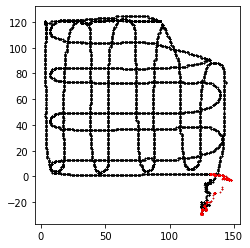

In [3]:
echogram6mph.see_range([-800, -1])

In [4]:
echogram6mph.crop_data(0,2200)
echogram6mph.crop_data(-1, -800, -1) # start from -1 to delete the last element 

length:  19785


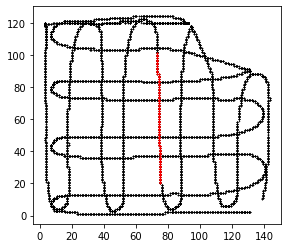

In [5]:
image_start = 3500
image_end = 4100
df2 = echogram6mph.df
print("length: ",len(df2['longitude']))
echogram6mph.see_range([image_start,image_end])

In [6]:
def lat_lon_to_meters(lon, lat):
        """ Convert longitude and latitude to global X and Y coordinates in meters
        """
        # Using Spherical Pseudo-Mercator projection
        # https://wiki.openstreetmap.org/wiki/Mercator
        R =  6378137.0
        Y = np.log(np.tan(np.pi / 4 + np.radians(lat) / 2)) * R
        X = np.radians(lon) * R
        X = X - X[0]
        Y = Y - Y[0]
        return X, Y
    
def get_distance(x,y):
    """calculates the euclidean distance for a sequence of points in the x and y coordinate
    """
    dx = np.diff(x)
    dy = np.diff(y)
    return np.add.accumulate(np.sqrt(dx**2 + dy**2))

X, Y = lat_lon_to_meters(df2["longitude"].to_numpy(), df2["latitude"].to_numpy())
df2["X_m"] = X
df2["Y_m"] = Y
distance = get_distance(X, Y)
distance = np.append(distance, distance[-1])
df2["distance_m"] = distance

In [7]:
# distance = get_distance(df2["X_m"], df2["Y_m"])
# distance = np.append(distance, distance[-1])
# df2["distance_m"] = distance

# **Point Cloud Generation**

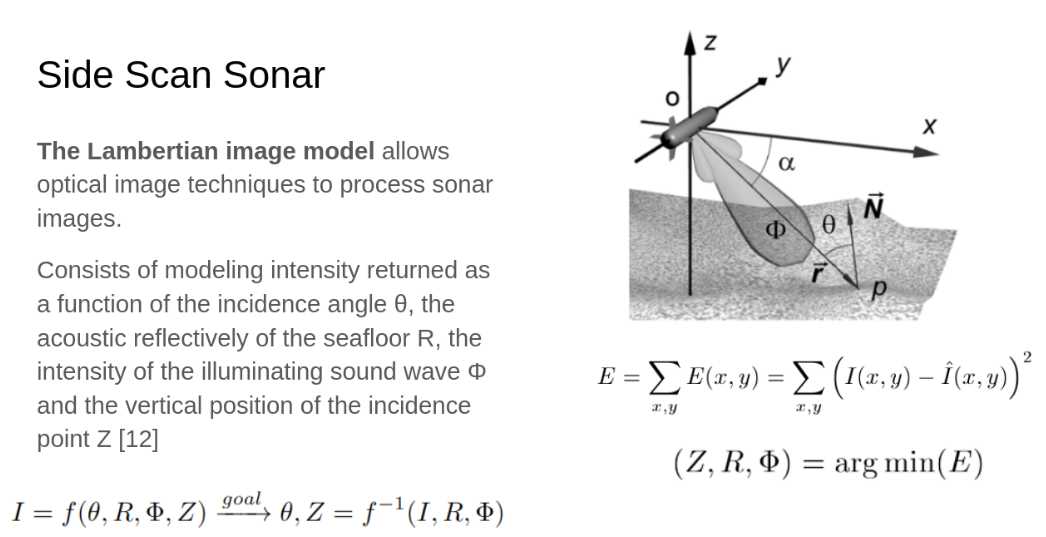

## Scale intensity values using min max normalization and visualize

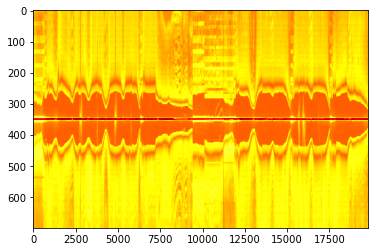

In [8]:
plt.imshow(echogram6mph.echo, cmap='hot',aspect='auto')

#### Visualize the sonar image

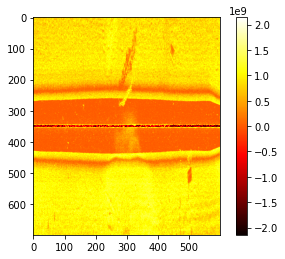

In [9]:
plt.imshow(echogram6mph.echo[:,image_start:image_end], cmap='hot')
plt.colorbar()

sss shape:  (700, 19785)
min intensity= -2142878100.0
max intensity= 2141233300.0
min intensity= 0.1266961
max intensity= 0.9720802


Text(0.5, 0, 'Data points')

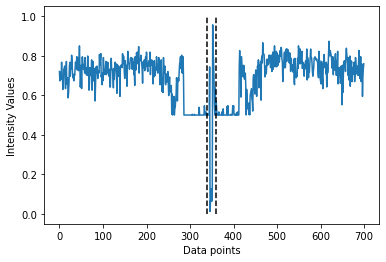

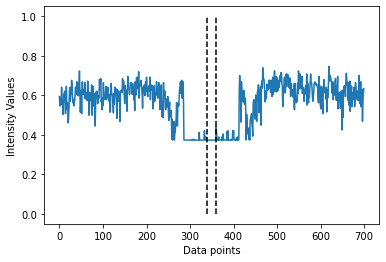

In [10]:
#sss = plt.imread('./images/sss.png') # image file, ndarray, with shape: (288, 432, 4)

sss_intensity_raw = echogram6mph.echo
rows, columns = sss_intensity_raw.shape  
print("sss shape: ", sss_intensity_raw.shape)
vmin = np.min(sss_intensity_raw)
vmax = np.max(sss_intensity_raw)
print("min intensity=",vmin)
print("max intensity=",vmax)
sss_intensity_raw = (sss_intensity_raw - vmin) / (vmax - vmin)

# Example of a single strip os sss data
fig, ax = plt.subplots()
ax.plot(range(700),sss_intensity_raw[:,image_start+1000])
ax.plot(np.array([360]*2),[0,1], '--k', label='range')
ax.plot(np.array([340]*2),[0,1], '--k', label='range')
ax.set_ylabel("Intensity Values")
ax.set_xlabel("Data points")

sss_intensity_raw[340:360, :] = 0.5
vmin2 = np.min(sss_intensity_raw)
vmax2 = np.max(sss_intensity_raw)
print("min intensity=",vmin2)
print("max intensity=",vmax2)
sss_intensity_raw = (sss_intensity_raw - vmin2)

# Example of a single strip os sss data
fig, ax = plt.subplots()
ax.plot(range(700),sss_intensity_raw[:,image_start+1000])
ax.plot(np.array([360]*2),[0,1], '--k', label='range')
ax.plot(np.array([340]*2),[0,1], '--k', label='range')
ax.set_ylabel("Intensity Values")
ax.set_xlabel("Data points")

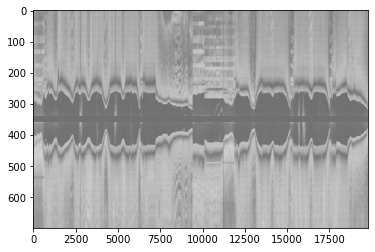

In [11]:
plt.imshow(sss_intensity_raw, cmap='gray',aspect='auto')

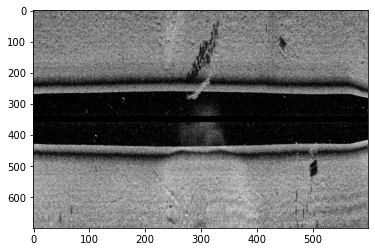

In [12]:
sss_intensity = sss_intensity_raw[:, image_start:image_end]
rows, columns = sss_intensity.shape  
plt.imshow(sss_intensity, cmap='gray',aspect='auto')

Text(0.5, 0, 'Data points')

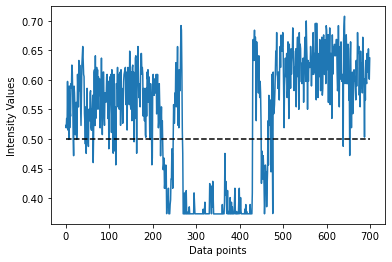

In [13]:
# Example of a single strip os sss data
fig, ax = plt.subplots()
ax.plot(range(700),sss_intensity[:,6])
ax.plot([0,700], np.array([0.5]*2), '--k', label='range')
ax.set_ylabel("Intensity Values")
ax.set_xlabel("Data points")

#### Sonar parameters

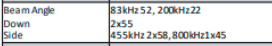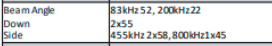60 to 85 degrees  Source:https://www.sportfishingmag.com/how-imaging-sonar-helps-you-find-fish/
<div>
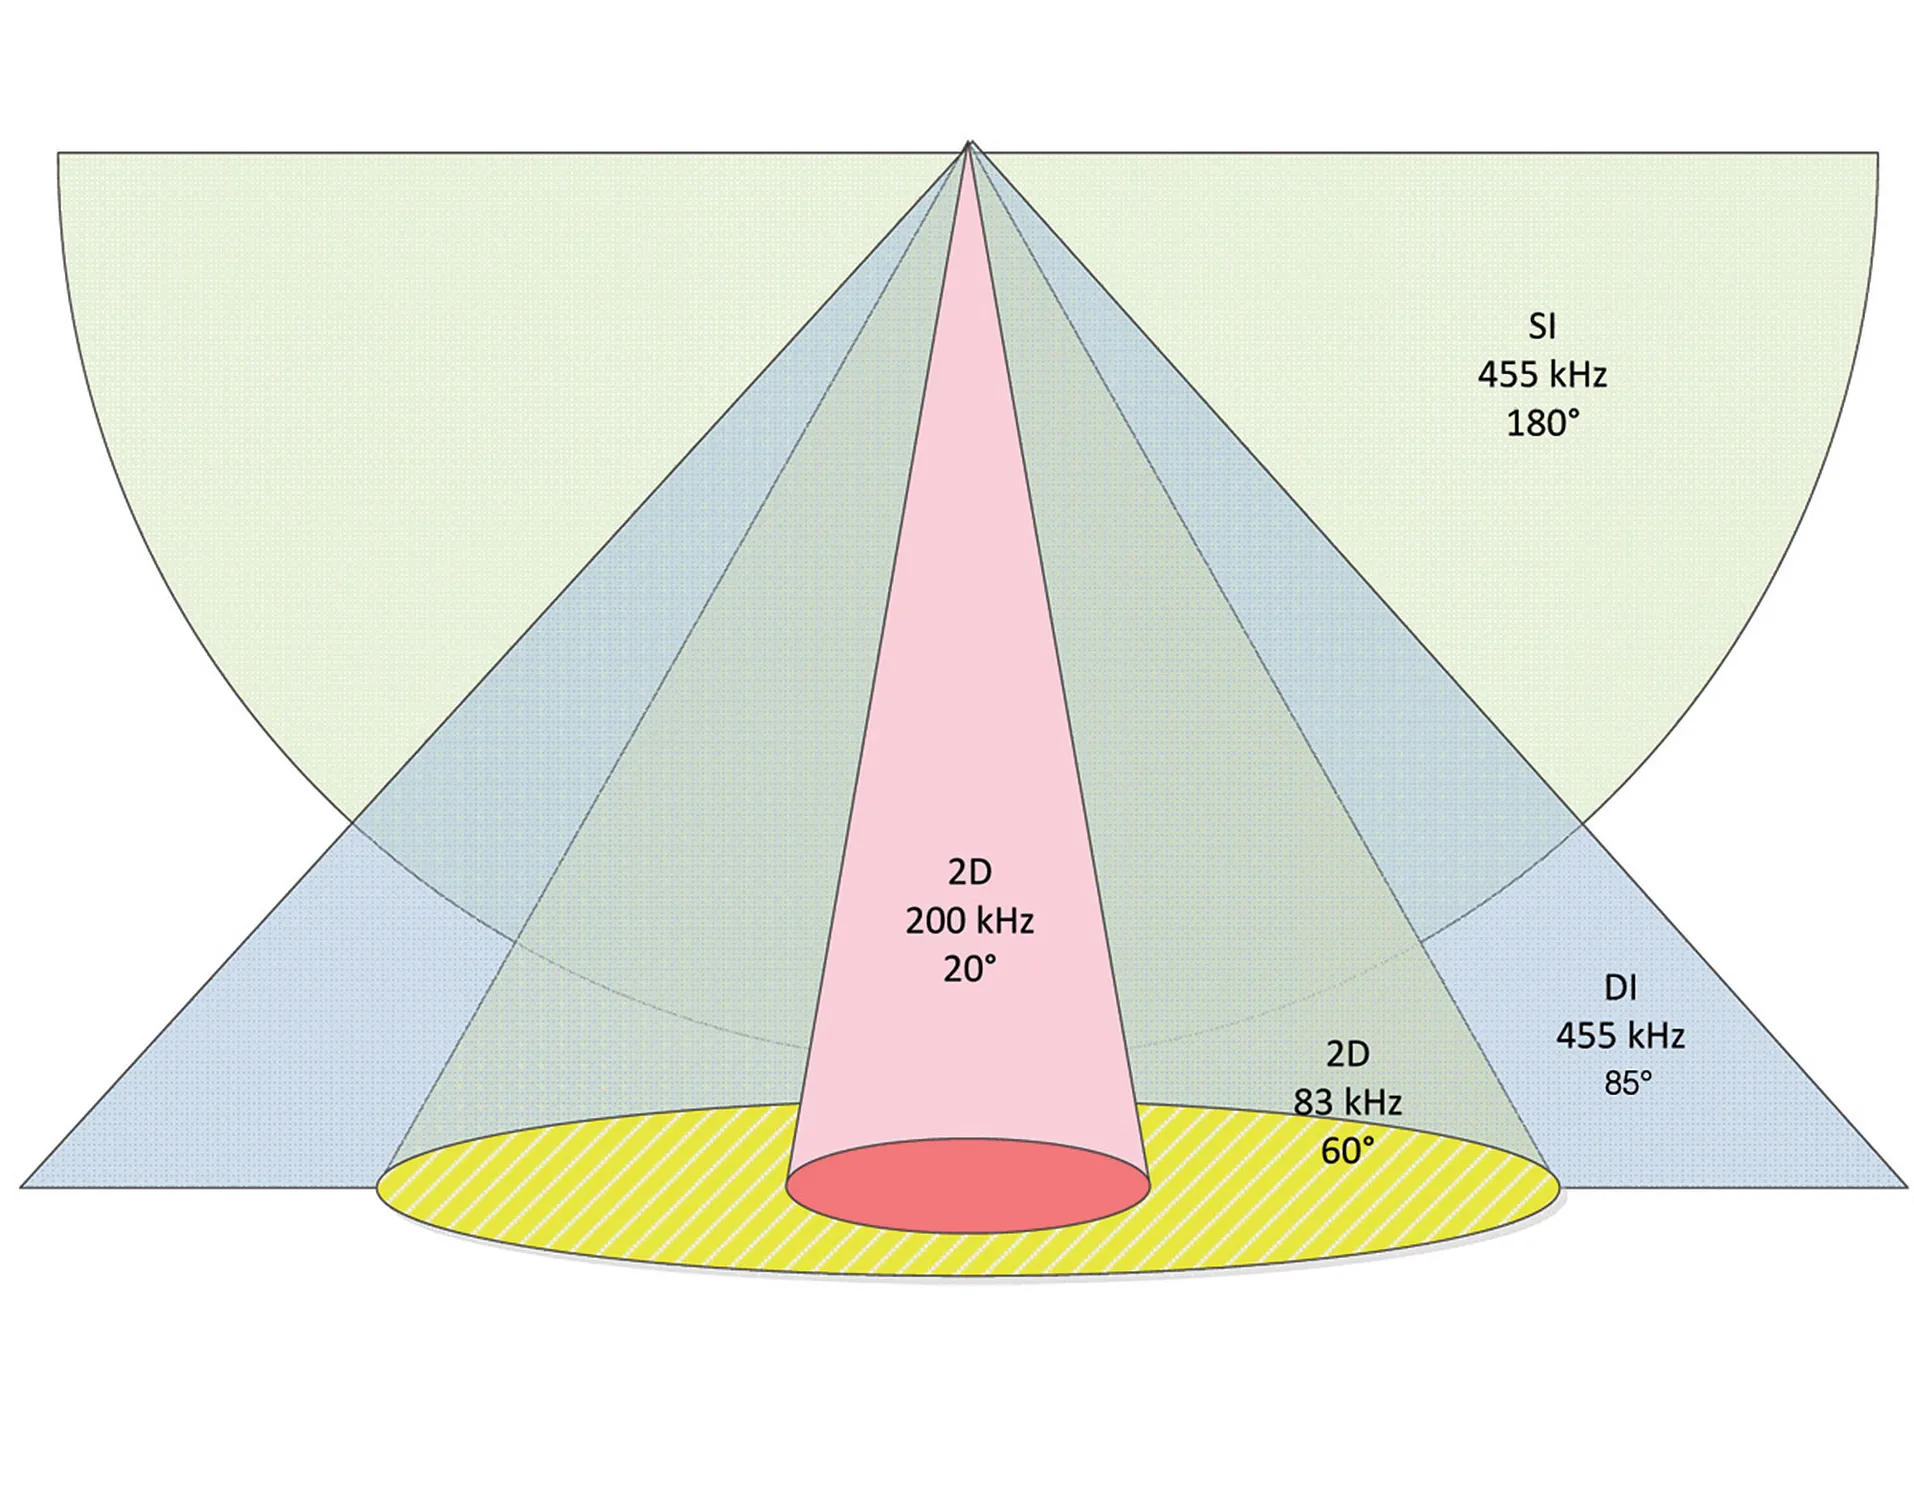
</div>

### Initialize X, Z and Y matrices

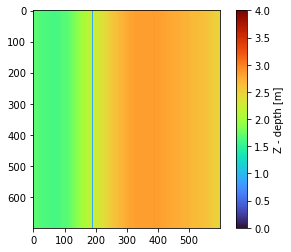

In [14]:
#df2 = pd.DataFrame(echogram6mph.data)
## Z
depth_m = df2.loc[image_start:image_end,:]['water_depth_m'].to_numpy()  # ndarray shape: (801,)
depth_m = depth_m[0:-1] # eliminate last column to agree with sonar shape
Z0 = np.tile(depth_m, (rows, 1))  # grid of depth values repeated in per row in meters (TO REPEAT AN ARRAY AS A ROW)
plt.imshow(Z0, cmap='turbo', vmin=0, vmax=4)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Z - depth [m]')
## X
x_m = df2.loc[image_start:image_end,:]['distance_m'].to_numpy()[0:-1]
x_m = x_m - x_m[0]
x_m = np.tile(x_m, (rows, 1))


Text(0, 0.5, 'x [m]')

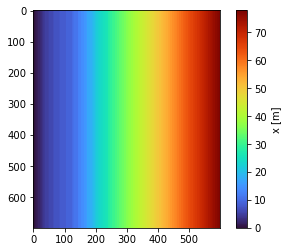

In [15]:
plt.imshow(x_m, cmap='turbo')
cbar = plt.colorbar()
cbar.ax.set_ylabel('x [m]')

### Angles:

<div>
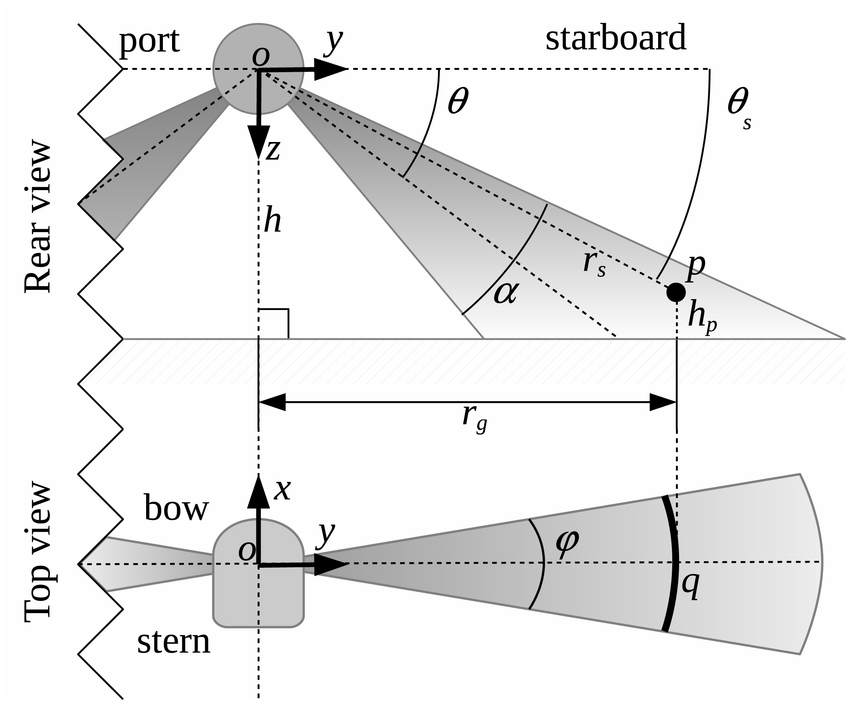
</div>

Text(0, 0.5, 'angles [rad]')

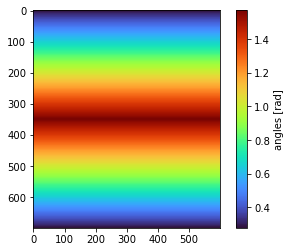

In [16]:
# Fixed Coordinate system: x - front, y - right, z - down 
alpha = 58 # from lowrance
theta = 45
theta_max = theta + alpha/2
theta_min = theta - alpha/2
angles_rad = np.radians(np.concatenate((np.linspace(theta_min,90,int(rows/2)),np.linspace(90,theta_min,int(rows/2))))) # array of angles starting at zero, 90deg at the middle and then zero
angles_rad = np.transpose([angles_rad] * columns)  # TO REPEAT AN ARRAY AS A COLUMN

## Y
y_m = np.zeros((rows, columns))
y_m = np.divide(Z0, np.tan(angles_rad))
y_m[0:350,:] = y_m[0:350]*(-1)
plt.imshow(angles_rad, cmap='turbo', interpolation='nearest')
cbar = plt.colorbar()
cbar.ax.set_ylabel('angles [rad]')


Text(0, 0.5, 'y coord [m]')

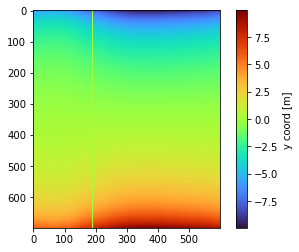

In [17]:
plt.imshow(y_m, cmap='turbo', interpolation='nearest')
cbar = plt.colorbar()
cbar.ax.set_ylabel('y coord [m]')

# Coiras, et al.Replication

### Initialize phi, K_reflec, and I_max matrices

/tmp/ipykernel_161/1848264717.py:6: RuntimeWarning: divide by zero encountered in true_divide
  I_max0 = np.divide(-Z0 + np.divide(x_m**2*(1+dy*Z0)**2,-Z0), np.sqrt(x_m**2+Z0**2)*(1+(dy*Z0)**2 + np.divide(x_m**2*(1+(dy*Z0)**2),-Z0**2)))
/tmp/ipykernel_161/1848264717.py:6: RuntimeWarning: invalid value encountered in true_divide
  I_max0 = np.divide(-Z0 + np.divide(x_m**2*(1+dy*Z0)**2,-Z0), np.sqrt(x_m**2+Z0**2)*(1+(dy*Z0)**2 + np.divide(x_m**2*(1+(dy*Z0)**2),-Z0**2)))


Text(0, 0.5, 'Phi intitialized')

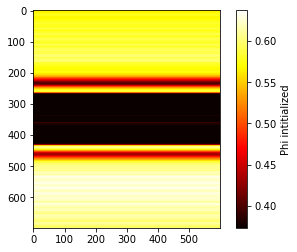

In [18]:
lambda_cons = 0.25
# Reflectivity
R0 = np.ones((rows, columns))*0.9  # reflectivity (typically from 0 to 1)
dy = np.diff(y_m, axis=0)
dy = np.concatenate((dy, dy[-1, :].reshape(1, columns)), axis=0) # make dy to have same shape as y_m
I_max0 = np.divide(-Z0 + np.divide(x_m**2*(1+dy*Z0)**2,-Z0), np.sqrt(x_m**2+Z0**2)*(1+(dy*Z0)**2 + np.divide(x_m**2*(1+(dy*Z0)**2),-Z0**2)))
K_reflec0 = np.divide(1, I_max0) 

# Beam Profile
Phi0 = np.copy(sss_intensity)
for ii in np.arange(rows):
        Phi0[ii, :] = np.median(Phi0[ii, :])  # Phi(x,y)=Median{Phi(x0,y0)|alpha(x0,y0)=alpha(x,y)}        
plt.imshow(Phi0, cmap='hot')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Phi intitialized')

Imax max value:  nan
Imax min value:  nan
Reflectivity max value:  nan
Reflectivity min value:  nan


Text(0, 0.5, 'Reflectivity (K) intitialized')

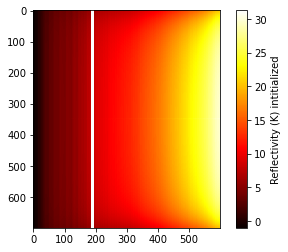

In [19]:
print("Imax max value: ", np.max(I_max0))
print("Imax min value: ", np.min(I_max0))
print("Reflectivity max value: ", np.max(K_reflec0))
print("Reflectivity min value: ", np.min(K_reflec0))
plt.imshow(K_reflec0, cmap='hot')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Reflectivity (K) intitialized')

### Finite Differences

std =  0.047054259117844624


/tmp/ipykernel_161/3282490918.py:11: RuntimeWarning: invalid value encountered in true_divide
  dZ_dy_1 = np.divide(np.diff(Z0, axis=0),dy1)


Text(0, 0.5, 'Finite difference debug')

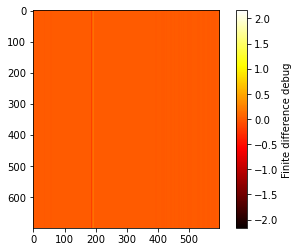

In [20]:
#from scipy.ndimage import gaussian_filter1d
#dZ3 = 100000*gaussian_filter1d(Z0,  axis=0, sigma=5, order=2, mode='wrap') #= np.gradient(Z, axis=1, )#edge_order=2

dx1 = np.diff(x_m, axis=1)
dx1[dx1 == 0] = np.nan
print("std = ",  np.nanstd(dx1))
dx1[dx1 < (np.nanmean(dx1) - np.nanstd(dx1))] = np.nanmean(dx1) - np.nanstd(dx1)
dx1[:,:] = np.nanmean(dx1)
dy1 = np.diff(y_m, axis=0)
dZ_dx_1 = np.divide(np.diff(Z0, axis=1), dx1)
dZ_dy_1 = np.divide(np.diff(Z0, axis=0),dy1)

dx2 = np.gradient(x_m, axis=1)
dx2[dx2 < 0.2] = 0.2
dy2 = np.gradient(y_m, axis=0)
dy2[dy2 < 0.25] = 0.25
dZ_dx_2 = np.divide(np.gradient(Z0, axis=1), dx2)
dZ_dy_2 = np.divide(np.gradient(Z0, axis=0), dy2)

plt.imshow(dZ_dx_1, cmap='hot')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Finite difference debug')

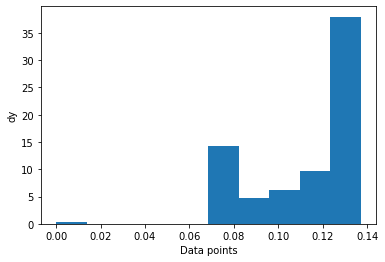

In [21]:
#debugging 
plt.hist(dy1[0,:], density=True, bins=10)  # density=False would make counts
plt.ylabel('dy')
plt.xlabel('Data points');
#x_m[0,:]

Text(0, 0.5, 'Finite difference debug')

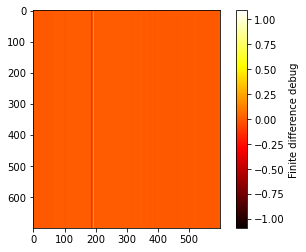

In [22]:
plt.imshow(np.gradient(Z0, axis=1), cmap='hot')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Finite difference debug')

## **Point Cloud Generation Algorithm**

0 ,jj : 1
E:  nan


/tmp/ipykernel_161/2078706917.py:31: RuntimeWarning: invalid value encountered in true_divide
  dZ_dy = np.divide(np.gradient(Z, axis=0),dy1)


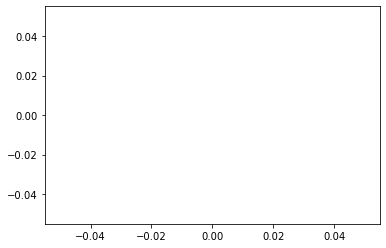

In [23]:
## Restart values
R = np.copy(R0)
Phi = np.copy(Phi0)        
Z = np.copy(Z0)

I_max = np.copy(I_max0)
K_reflec = np.copy(K_reflec0)

E_array = [] # Error stack
jj = 0 # iteration variable
E = 1  # Initial Error

dx1 = np.gradient(x_m, axis=1)
dx1[dx1 == 0] = np.nan
dx1[dx1 < (np.nanmean(dx1) - np.nanstd(dx1))] = np.nanmean(dx1) - np.nanstd(dx1)
dx1[:,:] = np.nanmean(dx1)

#--------------------------------------------------------------------------------------------------#
    
# Optimization algorithm

#if jj == 0:
while (E > 0.1):
    ## Recompute y matrix
    y = np.divide(Z, np.tan(angles_rad))  #in meters
    y[0:350,:] = y[0:350]*(-1)
    
    ## Partial Derivatives by Finite Difference
    dy1 = np.gradient(y, axis=0)
    dZ_dx = np.divide(np.gradient(Z, axis=1), dx1)
    dZ_dy = np.divide(np.gradient(Z, axis=0),dy1)

    ## Error 
    I_hat = -K_reflec*Phi*R*np.divide(Z - x_m*dZ_dx, np.sqrt(x_m**2+Z**2)*np.sqrt(dZ_dx**2 + dZ_dy**2 + 1))
    E = np.sum((sss_intensity - I_hat)**2)
        
    ## Optimization (expectation maximization)
    R = R + 2*lambda_cons*I_hat*np.divide(sss_intensity - I_hat,R)
    Phi = Phi + 2*lambda_cons*I_hat*np.divide(sss_intensity - I_hat,Phi)
    Z = Z - 2*lambda_cons*I_hat*(sss_intensity - I_hat)*( np.divide(- dZ_dy - dZ_dx,1 + dZ_dy**2 + dZ_dx**2) + np.divide(1 + x_m, x_m*dZ_dx - Z) + np.divide(Z, x_m**2 + Z**2))
    
    # Regularization
    #for ii in np.arange(rows):
    #    Phi[ii, :] = np.median(Phi[ii, :])  # Phi(x,y)=Median{Phi(x0,y0)|alpha(x0,y0)=alpha(x,y)}
                          
    I_max = np.divide(-Z + np.divide(x_m**2*(1+dy1*Z)**2,-Z), np.sqrt(x_m**2+Z**2)*(1+(dy1*Z)**2 + np.divide(x_m**2*(1+(dy1*Z)**2),-Z**2)))
    K_reflec = np.divide(1, I_max)    
    
    E_array.append(E)
    print(jj, ",", end = '')
    jj += 1
    
    if jj == 5:
        print("\nDone")
        break
    
print("jj :", jj)
print("E: ", E)

# Plot error stack
plt.plot(np.arange(jj), E_array[0:jj])

Text(0, 0.5, 'debug')

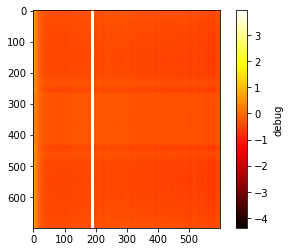

In [24]:
temp = np.copy(I_hat)
plt.imshow(temp, cmap='hot')
cbar = plt.colorbar()
cbar.ax.set_ylabel('debug')

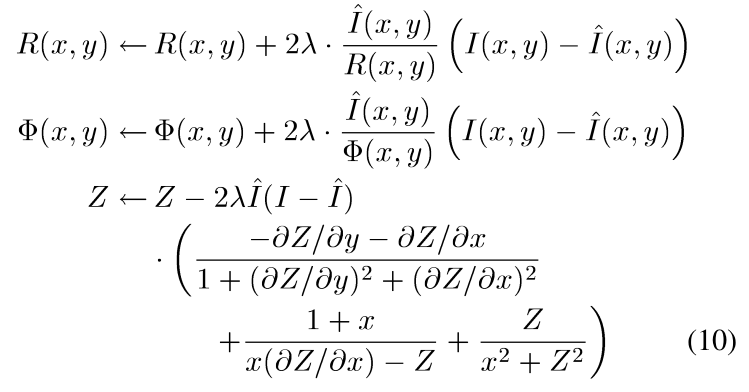

Median 0.00032771483280782016


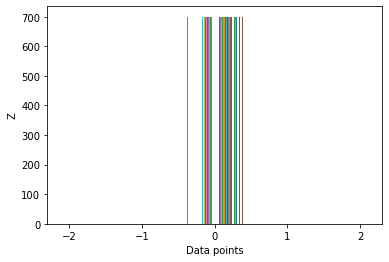

In [25]:
# Plot histogram of z matrix for debugging 
temp = np.copy(dZ_dx)
plt.hist(temp, bins=10)  # density=False would make counts
plt.ylabel('Z')
plt.xlabel('Data points');
print('Median', np.median(temp))

value:  0.1065300028895137


Text(0, 0.5, 'debug')

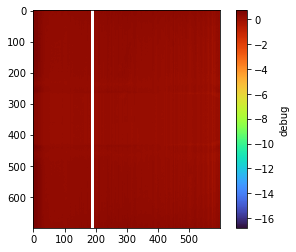

In [26]:
# Visualize phi matrix for debugging
#Phi + 2*lambda_cons*I_hat*np.divide(sss_intensity-I_hat,Phi)
print("value: ",Phi[300,200])
plt.imshow(Phi, cmap='turbo')
cbar = plt.colorbar()
cbar.ax.set_ylabel('debug')

In [27]:
# check number of empty values in error stack for debugging
np.count_nonzero(~np.isnan(E_array))

0

# Alternative methods 

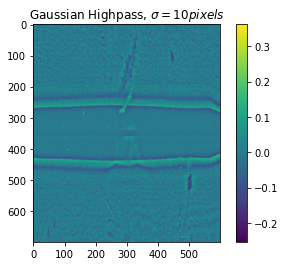

In [28]:
from scipy import ndimage

# Another way of making a highpass filter is to simply subtract a lowpass
# filtered image from the original. Here, we'll use a simple gaussian filter
# to "blur" (i.e. a lowpass filter) the original.
lowpass = ndimage.gaussian_filter(sss_intensity, 10)
gauss_highpass = sss_intensity - lowpass
plt.imshow(gauss_highpass)
plt.title(r'Gaussian Highpass, $\sigma = 10 pixels$')
cbar = plt.colorbar()


Text(0.5, 0, 'Data points')

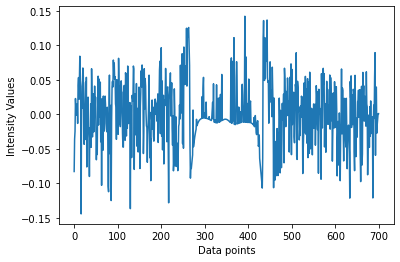

In [29]:
# Example of a single strip os sss data
fig, ax = plt.subplots()
plt.plot(range(700),gauss_highpass[:,100])
ax.set_ylabel("Intensity Values")
ax.set_xlabel("Data points")


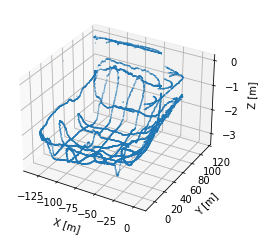

In [30]:
## Plot the point cloud
#plt.scatter(x,y,color=Z)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df2["X_m"],df2["Y_m"],-df2['water_depth_m'], s=0.1)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
plt.show()

In [31]:
pc = pd.DataFrame({'x': df2["X_m"], 'y': df2["Y_m"], 'z': -df2['water_depth_m']})

print("Checking the PC variable exists. First element: ", pc['x'].to_numpy()[0])
with open('processed_data/PC.txt', 'wb') as file:
    # A new file will be created
    pickle.dump(pc, file)

Checking the PC variable exists. First element:  0.0


Text(0, 0.5, 'Z (depth) [m]')

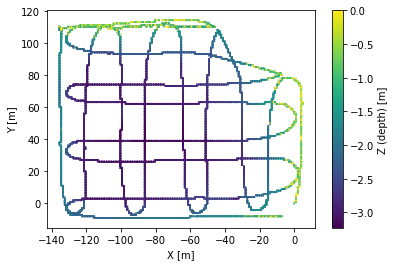

In [40]:
plt.scatter(df2["X_m"],df2["Y_m"], c=-df2['water_depth_m'], s=0.5)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Z (depth) [m]')

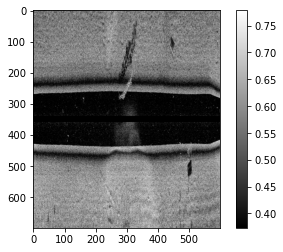

In [41]:
plt.imshow(sss_intensity, cmap='gray')
plt.colorbar()

Text(0.5, 0, 'Data points')

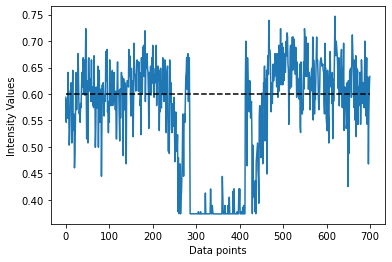

In [42]:
fig, ax = plt.subplots()
ax.plot(range(700),sss_intensity_raw[:,image_start+1000])
ax.plot([0,700], np.array([0.6]*2), '--k', label='range')
ax.set_ylabel("Intensity Values")
ax.set_xlabel("Data points")

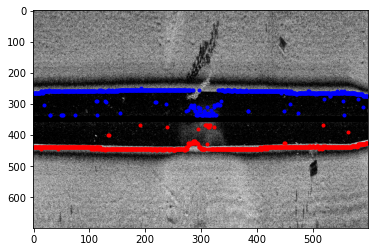

In [48]:
start = 0
stop = sss_intensity.shape[1]-1
threshold = 0.5

def find_first_return_and_plot(sss_intensity, start, stop, threshold, marker_size=-0.5):
    first_return = pd.DataFrame({'l':np.zeros(stop-start), 'r':np.zeros(stop-start)}, index =range(start, stop))
    kk = 0
    iir = 0
    iil = 0
    for jj in range(start, stop):
        iir = 0 if np.isnan(iir) else np.max([iir - 100, 0])
        iil = 0 if np.isnan(iil)  else np.max([iil - 100, 0])
        rigth_intensity = 0
        left_intensity = 0
        while (rigth_intensity < threshold or left_intensity < threshold): 
            if iil > 200 or iir > 200 or np.isnan(iir) or np.isnan(iil):
                iir = 200
                iil = 200
                break
            if rigth_intensity < threshold:
                rigth_intensity = sss_intensity[350+iir, jj]
                iir += 5
            if left_intensity < threshold:
                left_intensity = sss_intensity[350-iil, jj]
                iil += 5
        first_return.loc[kk] = [iir, iil]
        kk += 1
        if kk % 1000 == 0: print(kk,end = ',')

    plt.figure()
    plt.imshow(sss_intensity, cmap='gray', aspect='auto')
    #plt.colorbar()
    plt.plot(np.arange(start, stop), 350-first_return['l'].to_numpy(dtype='int'), 'ob', ms=marker_size)
    plt.plot(np.arange(start, stop), 350+first_return['r'].to_numpy(dtype='int'), 'or', ms=marker_size)

    #print(first_return)
    return first_return

first_return = find_first_return_and_plot(sss_intensity, start, stop, threshold, 3)

In [49]:
sind = lambda degrees: np.sin(np.deg2rad(degrees))
cosd = lambda degrees: np.cos(np.deg2rad(degrees))

#theta_max = 70
flat_index = 45 #placeholder

print('theta max: ', theta_max)

def generate_sparse_PC(sss_intensity, df2, first_return, flat_index, theta_max, image_start=0, is_print=False):
    pixel = first_return.loc[flat_index][0]
    water_depth = df2["water_depth_m"].to_numpy()[image_start+flat_index]
    dist_per_pixel = water_depth/pixel

    distance_r = first_return['r'].to_numpy()*dist_per_pixel  
    depth_first_return_r = distance_r*sind(theta_max)
    y_first_return_r = distance_r*cosd(theta_max)

    distance_l = first_return['l'].to_numpy()*dist_per_pixel  
    depth_first_return_l = distance_l*sind(theta_max)
    y_first_return_l = distance_l*cosd(theta_max)

    print('depth: ', depth_first_return_r[image_start + 100] - df2["water_depth_m"].to_numpy()[image_start+100]) # random depth
    print('side dist: ', y_first_return_r[image_start + 100])
    
    print('df2 size: ', df2["X_m"].size)
    heading_vec = np.transpose([df2["X_m"].to_numpy()[1:] - df2["X_m"].to_numpy()[0:-1], df2["Y_m"].to_numpy()[1:] - df2["Y_m"].to_numpy()[0:-1], [0]*(df2["Y_m"].size-1)])
    heading_vec = np.vstack((heading_vec, heading_vec[-1,:]))
    perpendicular_vec_r = np.cross(heading_vec, np.tile(np.array([0,0,1]), (heading_vec.shape[0],1)))  # vector to right
    perpendicular_vec_l = np.cross(heading_vec, np.tile(np.array([0,0,-1]), (heading_vec.shape[0],1)))  # vector to left
    print(perpendicular_vec_r.shape)
    norm_r = np.linalg.norm(perpendicular_vec_r, axis=1)
    norm_r[norm_r == 0] = np.nan
    norm_l = np.linalg.norm(perpendicular_vec_l, axis=1)
    norm_l[norm_l == 0] = np.nan
    print('norm shape: ',norm_r.shape)
    perpendicular_vec_r = np.transpose(np.transpose(perpendicular_vec_r) / norm_r)
    perpendicular_vec_l = np.transpose(np.transpose(perpendicular_vec_l) / norm_l)
    print('perpend shape: ',perpendicular_vec_r.shape)
    
    print('number of nans in norm: ', np.sum(np.isnan(norm_r)))
    
          
    X_new_r = df2["X_m"].to_numpy()[image_start:image_start+sss_intensity.shape[1]-1] + perpendicular_vec_r[image_start:image_start+sss_intensity.shape[1]-1,0]*y_first_return_r  
    Y_new_r = df2["Y_m"].to_numpy()[image_start:image_start+sss_intensity.shape[1]-1] + perpendicular_vec_r[image_start:image_start+sss_intensity.shape[1]-1,1]*y_first_return_r  
    X_new_l = df2["X_m"].to_numpy()[image_start:image_start+sss_intensity.shape[1]-1] + perpendicular_vec_l[image_start:image_start+sss_intensity.shape[1]-1,0]*y_first_return_l  
    Y_new_l = df2["Y_m"].to_numpy()[image_start:image_start+sss_intensity.shape[1]-1] + perpendicular_vec_l[image_start:image_start+sss_intensity.shape[1]-1,1]*y_first_return_l  
    
    print('xnew shape: ', X_new_r.shape)
    print('number of nans in X_new: ', np.sum(np.isnan(X_new_r)))
    return (X_new_r, Y_new_r, depth_first_return_r, X_new_l, Y_new_l, depth_first_return_l)

X_new_r, Y_new_r, depth_first_return_r, X_new_l, Y_new_l, depth_first_return_l = generate_sparse_PC(sss_intensity, df2, first_return, flat_index, theta_max, image_start=0, is_print=True)

theta max:  74.0
depth:  -0.8182994705200196
side dist:  0.0
df2 size:  19785
(19785, 3)
norm shape:  (19785,)
perpend shape:  (19785, 3)
number of nans in norm:  17414
xnew shape:  (599,)
number of nans in X_new:  509


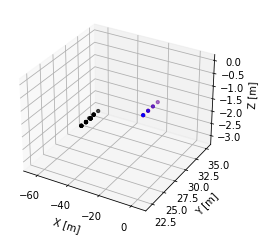

In [50]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_new_r[160:190],Y_new_r[160:190],-depth_first_return_r[160:190], s=10, c='r')
ax.scatter(X_new_l[160:190], Y_new_l[160:190],-depth_first_return_l[160:190], s=10, c='b')
ax.scatter(df2["X_m"].to_numpy()[image_start:image_end][160:190],df2["Y_m"].to_numpy()[image_start:image_end][160:190],-df2['water_depth_m'].to_numpy()[image_start:image_end][160:190], s=10, c='k')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
plt.show()

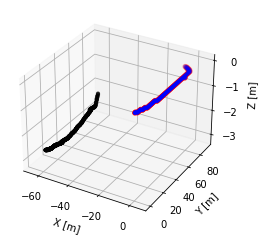

In [59]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_new_r, Y_new_r, -depth_first_return_r, s=20, c='r')
ax.scatter(X_new_l, Y_new_l, -depth_first_return_l, s=10, c='b')
ax.scatter(df2["X_m"].to_numpy()[image_start:image_end],df2["Y_m"].to_numpy()[image_start:image_end],-df2['water_depth_m'].to_numpy()[image_start:image_end], s=10, c='k')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
plt.show()

19784
1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,16000,17000,18000,19000,

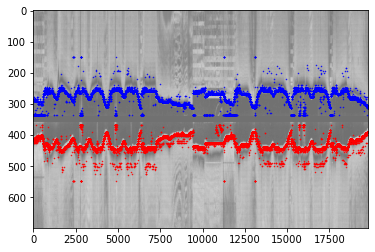

In [63]:
start = 0
stop = sss_intensity_raw.shape[1]-1
print(stop)
threshold = 0.57
first_return_complete = find_first_return_and_plot(sss_intensity_raw, start, stop, threshold, 0.5)

In [61]:
first_return_complete.describe()

l             r
count  19784.000000  19784.000000
mean      72.806814     78.339820
std       24.670028     21.305336
min       15.000000     20.000000
25%       60.000000     65.000000
50%       80.000000     80.000000
75%       90.000000     95.000000
max      200.000000    200.000000

In [64]:
print('theta max: ', theta_max)
X_new_r, Y_new_r, depth_first_return_r, X_new_l, Y_new_l, depth_first_return_l = generate_sparse_PC(sss_intensity_raw, df2, first_return_complete, flat_index=5000, theta_max=theta_max, image_start=0, is_print=True)

theta max:  74.0
depth:  1.0665698369530658
side dist:  0.540477576676307
df2 size:  19785
(19785, 3)
norm shape:  (19785,)
perpend shape:  (19785, 3)
number of nans in norm:  17414
xnew shape:  (19784,)
number of nans in X_new:  17413


In [ ]:
pc_r = pd.DataFrame({'x': X_new_r, 'y':  Y_new_r,'z': -depth_first_return_r})
print("Checking the PC_r variable exists. First element: ", pc_r['x'].to_numpy()[0])
with open('processed_data/PC_r.txt', 'wb') as file:
    # A new file will be created
    pickle.dump(pc_r, file)
    
pc_l = pd.DataFrame({'x': X_new_l, 'y':  Y_new_l,'z': -depth_first_return_l})
print("Checking the PC_l variable exists. First element: ", pc_l['x'].to_numpy()[0])
with open('processed_data/PC_l.txt', 'wb') as file:
    # A new file will be created
    pickle.dump(pc_l, file)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_new_r, Y_new_r, -depth_first_return_r, s=1, c='r')
ax.scatter(X_new_l, Y_new_l, -depth_first_return_l, s=1, c='b')
ax.scatter(df2["X_m"].to_numpy()[image_start:image_end],df2["Y_m"].to_numpy()[image_start:image_end],-df2['water_depth_m'].to_numpy()[image_start:image_end], s=10, c='k')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
plt.show()

In [ ]:
# debug

print(df2["X_m"].size)
heading_vec = np.transpose([df2["X_m"].to_numpy()[5700+1:5700+10] - df2["X_m"].to_numpy()[5700:5700+9], df2["Y_m"].to_numpy()[5700+1:5700+10] - df2["Y_m"].to_numpy()[5700:5700+9], [0]*(9)])
heading_vec = np.vstack((heading_vec, heading_vec[-1,:]))
print('heading: ',heading_vec)
for ii in range(heading_vec.shape[0]):
    perpendicular_vec = np.cross(heading_vec[ii,:], np.array([0,0,1]))  # vector to right
    perpendicular_vec = np.array([np.nan, np.nan, np.nan]) if np.linalg.norm(perpendicular_vec).all() == np.array([0,0,0]).all() else perpendicular_vec
    print('perp: ',perpendicular_vec / np.linalg.norm(perpendicular_vec))